In [81]:
import pandas as pd
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy import wcs

In [82]:
df = pd.read_csv('Data_Files/Galaxies.csv')

In [83]:
ra_min, ra_max = df['ra'].min(), df['ra'].max()
dec_min, dec_max = df['dec'].min(), df['dec'].max()

In [84]:
ra_min, ra_max

(45.09046, 63.41963)

In [85]:
dec_min, dec_max

(-41.79911, -30.14935)

In [86]:
step=1/2
grid_ra = np.arange(40, 67, step)
grid_dec = np.arange(-45, -25, step)

In [87]:
ra_size, dec_size = grid_ra.shape[0], grid_dec.shape[0]

In [88]:
w = wcs.WCS(naxis=2)
w.wcs.crpix = [ra_size/2, dec_size/2]
w.wcs.cdelt = np.array([(grid_ra[int(ra_size/2)]-grid_ra[int(ra_size/2)+1]), (grid_dec[int(dec_size/2)+1]-grid_dec[int(dec_size/2)])])
w.wcs.crval = [grid_ra[int(ra_size/2)], grid_dec[int(dec_size/2)]]
w.wcs.ctype = ["RA---SIN", "DEC--SIN"]
w.wcs.cunit = ["deg", "deg"]
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 53.5  -35.0  
CRPIX : 27.0  20.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.5  0.5  
NAXIS : 0  0

In [89]:
new_header = w.to_header().copy()
new_header['NAXIS']=2
new_header['NAXIS1']=ra_size
new_header['NAXIS2']=dec_size
new_wcs = wcs.WCS(new_header)

In [90]:
def get_box_coord(pix_ra, pix_dec, image_wcs):
  
    ra_next = image_wcs.pixel_to_world(pix_ra+0.5, pix_dec).ra.value
    dec_next = image_wcs.pixel_to_world(pix_ra, pix_dec+0.5).dec.value
    ra_prev = image_wcs.pixel_to_world(pix_ra-0.5, pix_dec).ra.value
    dec_prev = image_wcs.pixel_to_world(pix_ra, pix_dec-0.5).dec.value

    return ra_next, dec_prev, ra_prev, dec_next

In [91]:
output_map_shape = (new_header['NAXIS1'], new_header['NAXIS2'])
output_map_shape

(54, 40)

In [92]:
density = np.zeros(output_map_shape)
for i in range(output_map_shape[0]):
    for j in range(output_map_shape[1]):
        ra_min, dec_min, ra_max, dec_max = get_box_coord(i, j, new_wcs)
        mask = (df['ra']>=ra_min) & (df['ra']<=ra_max) & (df['dec']>=dec_min) & (df['dec']<=dec_max)
        density[i,j] = mask.sum()

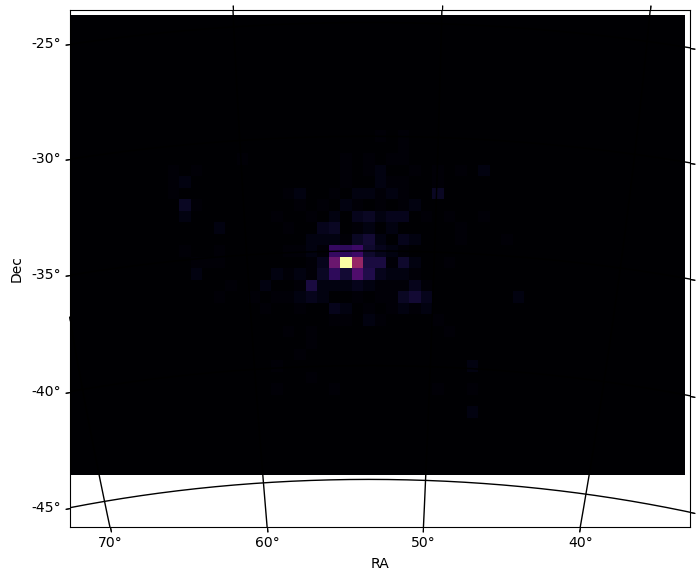

In [93]:
fig = plt.figure(1, figsize=(8, 8))
ax0 = plt.subplot(projection=new_wcs)
ra_ax = ax0.coords[0]
ra_ax.set_format_unit(unit='degree')
a=ax0.imshow(density.T, cmap='inferno')
#ax0.contour(gaussian_filter(density.T, 1), extent=[my_ra[0], my_ra[-1], my_dec[0], my_dec[-1]],
#            transform=ax0.get_transform('icrs'), colors='green', levels=np.logspace(-1, 1.672, 6))
#ax0.plot(ra, [dec_l]*100, color='red', lw=1, transform=ax0.get_transform('icrs'), linestyle='--')
#ax0.plot(ra, [dec_h]*100, color='red', lw=1, transform=ax0.get_transform('icrs'), linestyle='--')
#ax0.plot([ra_l]*100, dec, color='red', lw=1, transform=ax0.get_transform('icrs'), linestyle='--')
#ax0.plot([ra_h]*100, dec, color='red', lw=1, transform=ax0.get_transform('icrs'), linestyle='--')


#ax0.scatter(df['ra'],df['dec'], s=1, color='red', alpha=0.5, transform=ax0.get_transform('icrs'))

ax0.set_xlim(0, ra_size)
ax0.set_ylim(-5, dec_size)
ax0.set_xlabel('RA')
ax0.set_ylabel('Dec')
ax0.grid(color='black', lw=1)
#ax0.invert_xaxis()

In [94]:
hdu = fits.PrimaryHDU(density.T, new_header)
hdu.writeto('test_sqr_aper.fits', overwrite=True)